In [78]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from aotools import *
import matplotlib.patches as patches



%matplotlib inline

In [79]:
telescope_diameter = .356 # meter
central_obscuration =  0.13 #.114 # meter
central_obscuration_ratio = central_obscuration / telescope_diameter
#spider_width = 0.05 # meter   ##spiders not mentioned in celestron site
oversizing_factor =  147/128 #17 / 16  #NOT SURE
focallength_t = 3.910 #m
f_number = focallength_t/telescope_diameter 

focallength_l = 0.0145 #m
sh_pitch = .0005 #m
num_lenslets = 6 # lenslets along one diameter
sh_diameter = sh_pitch * num_lenslets #m
f_number_sh = focallength_l/sh_pitch
plate_scale = 0.55 #arcsec/pixel calculated in proposal doc
pixel_size = 3.45e-6 #m 
num_pupil_pixels = 1536 * oversizing_factor  # emccd is 2248x1536

wavelength = 0.55e-6  #NOT SURE
star_separation = 30 #in arcsec 

# Creating apertures and grids for the telescope

(3111696,) = num_pupil_pixels x num_pupil_pixels


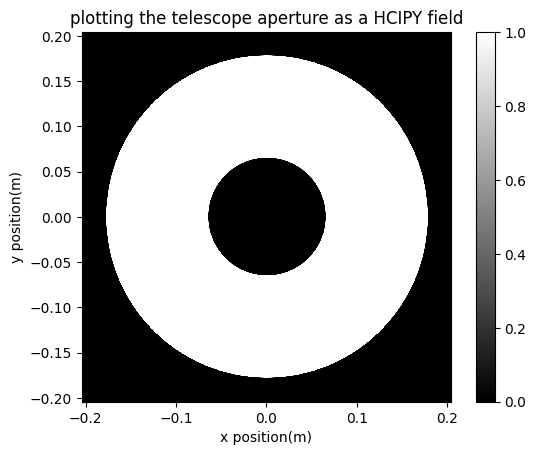

In [80]:
pupil_grid_diameter = telescope_diameter * oversizing_factor
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

shimm_aperture_generator = make_obstructed_circular_aperture(telescope_diameter,central_obscuration_ratio)
shimm_aperture = evaluate_supersampled(shimm_aperture_generator, pupil_grid, 4)


print(shimm_aperture.shape, '= num_pupil_pixels x num_pupil_pixels')


imshow_field(shimm_aperture, cmap='gray')
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.title('plotting the telescope aperture as a HCIPY field')
plt.show()

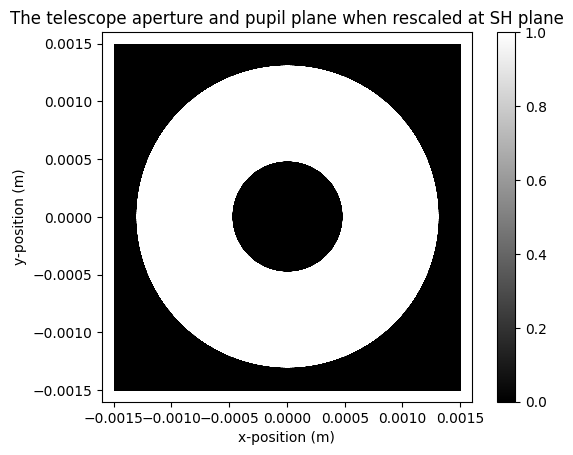

In [81]:
scaler_new = sh_diameter / pupil_grid_diameter  # we scaled the pupil grid to match the sh array
new_pupil_grid = pupil_grid.scaled(scaler_new)
new_shimm_aperture_generator = make_obstructed_circular_aperture(scaler_new * telescope_diameter,central_obscuration_ratio)
new_shimm_aperture = evaluate_supersampled(new_shimm_aperture_generator, new_pupil_grid, 4)

imshow_field(new_shimm_aperture, cmap='gray')
plt.xlabel('x-position (m)')
plt.ylabel('y-position (m)')
plt.xlim(-0.0016, 0.0016)
plt.ylim(-0.0016, 0.0016)
plt.title('The telescope aperture and pupil plane when rescaled at SH plane')
plt.colorbar()
plt.show()

# Creating the Shack-Hartmann spot pattern for an incoming planar wave with no aberrations

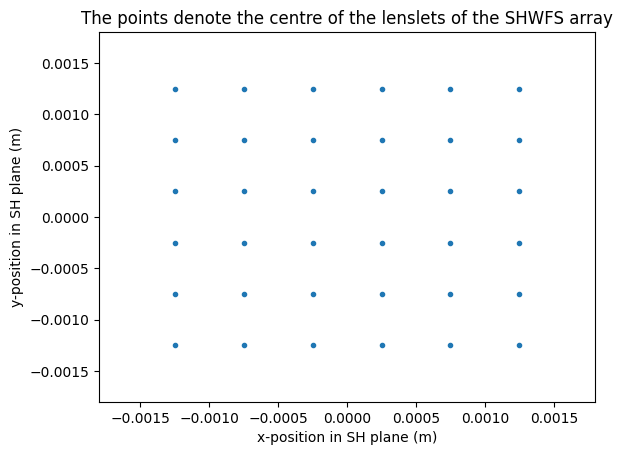

In [82]:

magnifier = Magnifier(scaler_new)


# print(pupil_grid_diameter, 'in m', 'is the diameter of the pupil plane just after telescope captures light')
# print(telescope_diameter, 'in m', 'is the diameter of the telescope aperture, or in other words the diameter of illuminated plane')

# print(sh_diameter, 'in m', 'is the sh_diameter = sh_pitch * num_lenslets')
# print(telescope_diameter * scaler_new, 'is the aperture of the telescope in the scaled frame on the SH plane')

lens_arr = np.arange(-sh_diameter/2 + sh_pitch/2, sh_diameter/2 - sh_pitch/2 + sh_pitch, sh_pitch) # we have rescaled the pupil plane to the sh plane
# print(*lens_arr, 'are positions of centres of the lenslets along xaxis')

lens_grid = CartesianGrid(SeparatedCoords((lens_arr, lens_arr)))
plt.plot(lens_grid.x, lens_grid.y, '.')
plt.xlim([-0.0018, 0.0018])
plt.ylim([-0.0018, 0.0018])
plt.xlabel('x-position in SH plane (m)')
plt.ylabel('y-position in SH plane (m)')
plt.title('The points denote the centre of the lenslets of the SHWFS array')
plt.show

# print(lens_grid.x, lens_grid.y)

x_pts = list(set(lens_grid.x))
y_pts = list(set(lens_grid.y)) 

x_pts = sorted(x_pts)
y_pts = sorted(y_pts)

# print(x_pts, y_pts)

edges = np.arange(min(x_pts)-sh_pitch/2, max(x_pts)+sh_pitch, sh_pitch) 
# print(edges)


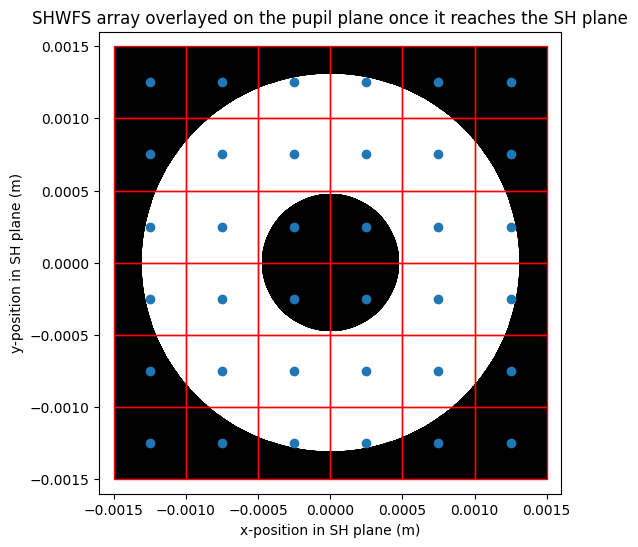

In [83]:

fig, ax = plt.subplots(figsize=(6, 6))

imshow_field(new_shimm_aperture, cmap='gray')

x_pts = list(set(lens_grid.x))
y_pts = list(set(lens_grid.y)) 

x_pts = sorted(x_pts)
y_pts = sorted(y_pts)

edges = np.arange(min(x_pts)-sh_pitch/2, max(x_pts)+sh_pitch, sh_pitch)

for i in edges[0:len(edges)-1]:
    for j in edges[0:len(edges)-1]:
        rectangle = patches.Rectangle((i, j), sh_pitch, sh_pitch, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rectangle)


ax.plot(lens_grid.x, lens_grid.y, 'o')
ax.set_xlim([-0.0016, 0.0016])
ax.set_ylim([-0.0016, 0.0016])
ax.set_xlabel('x-position in SH plane (m)')
ax.set_ylabel('y-position in SH plane (m)')
ax.set_title('SHWFS array overlayed on the pupil plane once it reaches the SH plane')
plt.show()

# print(lens_grid.x)
# print(lens_grid.y)

In [84]:
pos_star = np.array([0.0, 0.0])  #np.array([4.84e-4,4.84e-4])

#wf = Wavefront(shimm_aperture, wavelength)
wf = Wavefront(shimm_aperture * np.exp(2j * np.pi * np.dot(pos_star, pupil_grid.coords) / wavelength), wavelength)  
# is this to generalize wavefront based on arbitrary position of star and not just its centre ?
wf.total_power = 1

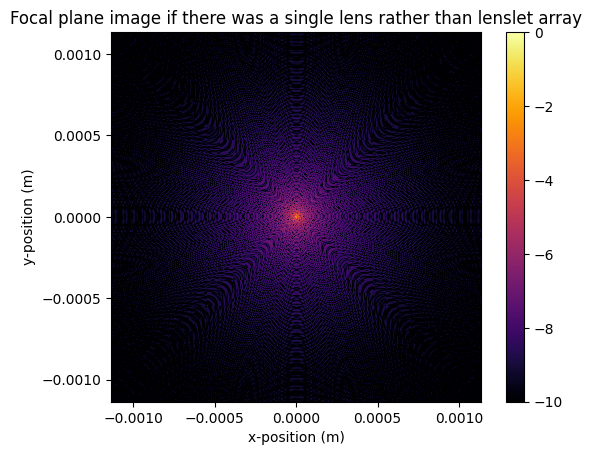

In [85]:
spatial_resolution = wavelength * f_number
focal_grid = make_focal_grid(q=5, num_airy=188, spatial_resolution=spatial_resolution)  
# required q is calculated from (spatial_resolution/pixel_size), comes out about 4.6. 
# Then num_airy is calculated by (num_lenslets*sh_pitch/spatial_reso), comes out 188 (should i use this?)

propagator = FraunhoferPropagator(pupil_grid, focal_grid)

unaberrated_PSF = propagator.forward(wf).power

imshow_field(np.log10(unaberrated_PSF / unaberrated_PSF.max()), cmap='inferno', vmin=-10)
plt.xlabel('x-position (m)')
plt.ylabel('y-position (m)')
plt.title('Focal plane image if there was a single lens rather than lenslet array')
plt.colorbar()
plt.show()

#print(spatial_resolution)

In [86]:
from hcipy.optics import MicroLensArray
lenslet_array = MicroLensArray(pupil_grid.scaled(scaler_new), lens_grid, focallength_l)
SHWFS = ShackHartmannWavefrontSensorOptics(pupil_grid.scaled(scaler_new), lenslet_array)


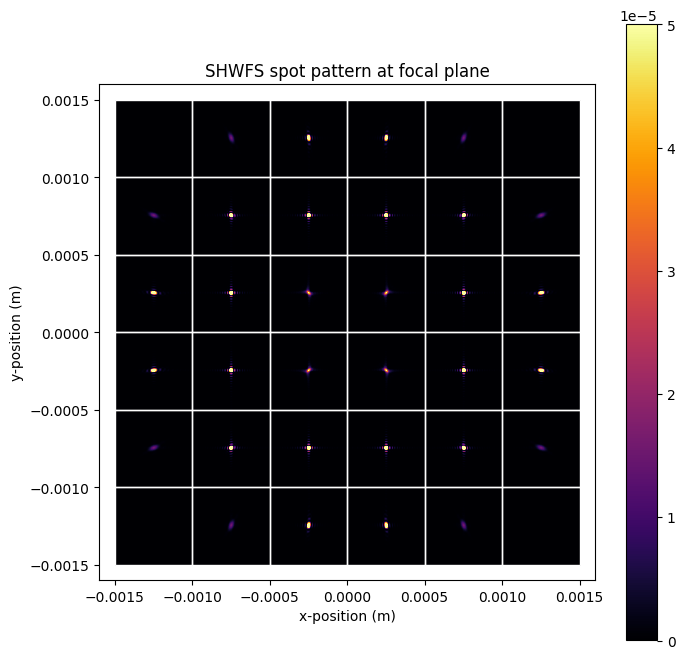

In [87]:
camera = NoiselessDetector(focal_grid)

pos_star = np.array([0,0]) #[4.84e-5,0.0])  #np.array([4.84e-4,4.84e-4])
wf = Wavefront(shimm_aperture * np.exp(2j * np.pi * np.dot(pos_star, pupil_grid.coords) / wavelength), wavelength)
#wf = Wavefront((np.sqrt(2.512))**1 *shimm_aperture, wavelength) #to increase magnitude of star by one multiply shimm_aperture by sqrt(2.512)?
wf.total_power = 1

camera.integrate(SHWFS(magnifier(wf)),1)

image_ref = camera.read_out()

fig, ax = plt.subplots(figsize=(8, 8))

imshow_field(image_ref, cmap='inferno', vmax=5.0e-5)#, grid_units= pixel_size, vmax=5.0e-5)
#plt.imshow(image_ref.reshape((1764,1764)), cmap='inferno', vmax=1.0e-5)


for i in edges[0:len(edges)-1]:
    for j in edges[0:len(edges)-1]:
        rectangle = patches.Rectangle((i, j), sh_pitch, sh_pitch, linewidth=1, edgecolor='w', facecolor='none')
        ax.add_patch(rectangle)

        
ax.set_xlim([-0.0016, 0.0016])
ax.set_ylim([-0.0016, 0.0016])
ax.set_xlabel("x-position (m)")
ax.set_ylabel("y-position (m)")
ax.set_title('SHWFS spot pattern at focal plane')
plt.colorbar()
plt.show()


In [93]:
# shwfse = ShackHartmannWavefrontSensorEstimator(SHWFS.mla_grid, SHWFS.micro_lens_array.mla_index)
# slopes_ref = shwfse.estimate([image_ref])


# print(slopes_ref)

# Creating turbulent phase screen

In [89]:
seeing = 4.0#0.25 #in arcseconds, at Hanle. but at what wavelength?
outer_scale = 40 # meter  ##what value for Hanle?
tau0 = 0.005 # seconds  ##what value for Hanle?

fried_parameter = seeing_to_fried_parameter(seeing)
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)
velocity = 0.314 * fried_parameter / tau0

print('r0   = {0:.3f}m'.format(fried_parameter))
print('L0   = {0:.1f}m'.format(outer_scale))
print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
print('v    = {0:.1f}m/s'.format(velocity))

r0   = 0.025m
L0   = 40.0m
tau0 = 5.0ms
v    = 1.6m/s


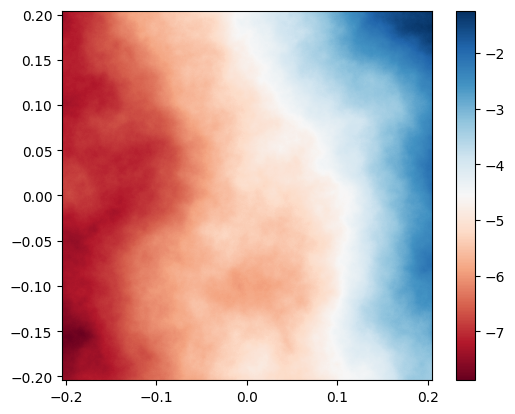

In [90]:
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

phase_screen_phase = layer.phase_for(wavelength) # in radian
phase_screen_opd = phase_screen_phase * (wavelength / (2 * np.pi)) * 1e6

imshow_field(phase_screen_opd, cmap='RdBu')#,vmin=-4, vmax=4)
plt.colorbar()

# Propagating the incoming wavefront through the phase screen

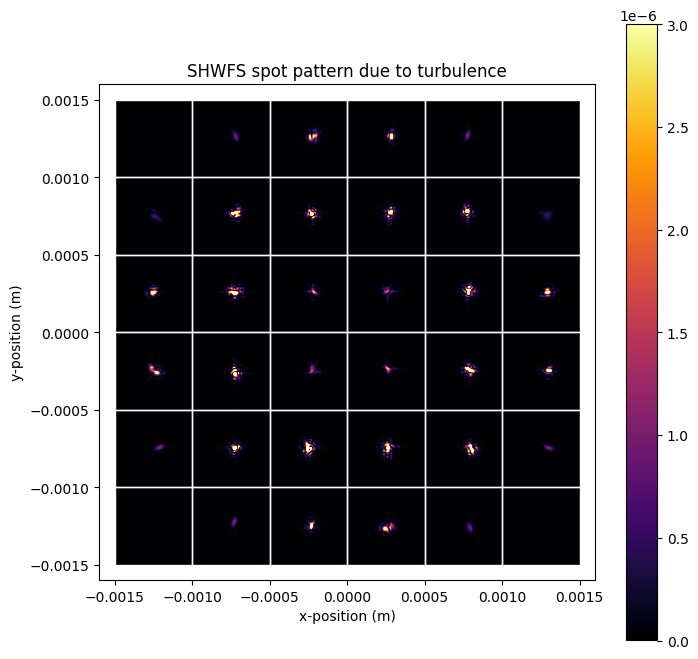

In [91]:
cpos_star = np.array([4.84e-5,0.0])  #np.array([4.84e-4,4.84e-4])
wf = Wavefront(shimm_aperture * np.exp(2j * np.pi * np.dot(pos_star, pupil_grid.coords) / wavelength), wavelength)
wf_atmos= layer(wf)  # made to propagate thru atmosphere

camera.integrate(SHWFS(magnifier(wf_atmos)), 1)

image_ref_atmos = camera.read_out()

fig, ax = plt.subplots(figsize=(8, 8))

imshow_field(image_ref_atmos, cmap='inferno',vmax=3.0e-6)
for i in edges[0:len(edges)-1]:
    for j in edges[0:len(edges)-1]:
        rectangle = patches.Rectangle((i, j), sh_pitch, sh_pitch, linewidth=1, edgecolor='w', facecolor='none')
        ax.add_patch(rectangle)

        
ax.set_xlim([-0.0016, 0.0016])
ax.set_ylim([-0.0016, 0.0016])
ax.set_xlabel("x-position (m)")
ax.set_ylabel("y-position (m)")
ax.set_title('SHWFS spot pattern due to turbulence')
plt.colorbar()
plt.show()


# slopes using HCIPY itself

In [92]:
shwfse = ShackHartmannWavefrontSensorEstimator(SHWFS.mla_grid, SHWFS.micro_lens_array.mla_index)
slopes_ref = shwfse.estimate([image_ref_atmos])


print(slopes_ref)

[[ 7.25286223e-05  2.05981249e-05  1.61986400e-05  6.05449386e-06
   3.56305059e-05 -6.20055276e-05  3.92300544e-05  2.37857669e-05
  -6.58087292e-07  1.15238581e-05  4.65675463e-05  4.15859135e-05
   1.02737223e-05  2.62096908e-05  2.16721318e-05  1.67421275e-05
   3.74770303e-05  4.59714743e-05 -9.05934758e-07  2.11486788e-05
   2.72678534e-05  1.40734113e-05  3.25125987e-05  4.03911700e-05
   1.96906105e-05  2.77006668e-05  1.99964658e-05  2.58830243e-05
   2.05445222e-05  2.44898802e-05  6.74148052e-05  2.70879094e-05
   2.68840563e-05  3.05246881e-05  1.93285084e-05 -6.67792915e-05]
 [ 6.90942865e-05  1.90939056e-05 -1.73592553e-06 -1.40179642e-05
  -6.16375019e-06  6.54974366e-05  1.34378927e-06 -1.36968626e-06
  -1.29250855e-06 -2.96790672e-06 -6.60472806e-06  2.99897075e-06
  -2.52743124e-06 -1.83885073e-05  3.18833115e-07  8.17819993e-06
   2.02168226e-06 -1.07391313e-06  4.72615998e-06  4.51874698e-06
   1.12807534e-05  7.25732930e-06  1.16165549e-05  3.82772470e-06
  -6.0046

# For binary star ?